# Business Understanding
First things first, following the CRISP-DM process methodology our first task is to understand the problem, from the dataset description we can see that it describes the listing activity of homestays in **Seattle**. Then according to the process we ask some questions that we want to be solved using the dataset. Some intriguing ones are: 
1. How much do time frames, influence AirBNB home earnings?
2. How can reviews affect the prices of AirBNB homes?
3. Does the internet availability affect the number of listings af an AirBNB home? and if so, should a host invest in making this service available for his listing?
4. Does Bed type matters?
5. How about cancelation policy?
6. Can we use this data to predict the price of an AirBNB home?

Now it's time to have a look at the data and try to understand it.

Import needed libraries

In [69]:
import re
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

pd.options.display.max_rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Read files in csv format

In [70]:
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

# Knowing the data 
First we get familiar with the data by knowing
* What percentage of these columns are null values? 
* what columns are available in the dataset? 
* If the data is to be fed to a machine learning algorithm, what would be the features and what would be the output of the model? 

Using these questions to impute or remove rows in this dataset as a predprocessing and prepration of the data

# Calendar Info

In [71]:
def table_info(table):
    """ 
    Show info of about the table 
  
    What percentage of these columns are null values?
    What columns are available in the dataset?
    Columns Datatype
  
    Parameters: 
    table (dataFrame): Dataframe containing the table values 
  
    Returns: 
    null_percent: Percentage of null values of columns 
  
    """
    print("Table: \n",table.head())
    print("Shape: ",table.shape)
    print("Types: \n",table.dtypes)
    null_percent = (table.isnull().sum()/table.shape[0]).sort_values(ascending=False)
    return null_percent

Table: 
    listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN
Shape:  (1393570, 4)
Types: 
 listing_id     int64
date          object
available     object
price         object
dtype: object


price         0.32939
available     0.00000
date          0.00000
listing_id    0.00000
dtype: float64

In [ ]:
table_info(calendar)

We can see that the calender dataset has 4 columns.
Next we will check the size of the dataset, the type of each column, and the percentage of null values for each column.

We see that the price column is where all the null values in this table occurs so we need to find this values and remove them but before any manipulation we go through the other tables also the data types of date should be date also price should be float and available should be boolean, so restructing the table must be done, considering the size of the table with more than million record

# Listings Info

We can see that this table has multiple of columns which can be used as features for machine learning models and for answering our questions.

In [ ]:
table_info(listings)

Showing all columns and percentage of null values in them to know which columns can be removed or if some values can be imputed
We can see that:
* There are 92 columns and 3818 record
* 2 columns can be considered completley contaning null values and 3 columns approximately in range of 50% null values 
* Joining can occur with calender using id and listing_id between this table and calendar table

# Reviews Info

In [ ]:
table_info(reviews)

Null values regarding reviews is unnoticebale so we can remove the few records with null comments
Also we could join the table with the others using listing_id

# Data Preparation
Multiple steps should be done to make sure data is ready for extracing answers:
* Removing unnecessary rows and columns
* Refactor data entries to be suitable for modeling
* Assigning the correct dtype for each column
* Imputing numerical values
* Encode categorical values
* Merging all dataframes into 1 dataframe

# Calendar Prepration

In [77]:
calendar = calendar[~calendar['price'].isnull()]
calendar.shape

(934542, 4)

In [78]:
calendar['available'].unique()

array(['t'], dtype=object)

We found a relation between having a price value and true aviailable value so the information the 'available' column presents is not needed where every record with price value is avaliable so the column should be removed

In [79]:
calendar.drop(['available'],inplace = True, axis = 1)

Then we check if all prices are in dollars or do we have other curriencies 

In [80]:
calendar[calendar['price'].apply(lambda x: '$' in x)].shape

(934542, 3)

Same number so all values are in dollars.

Then convert all pricies from objects dataType to float dataType so we can process them removing any special charachters

In [81]:
calendar['price'] = calendar['price'].apply(lambda x: int(float(re.sub('[$,]','',x))))

We convert all dates to datetime data type

In [82]:
calendar['date'] = pd.to_datetime(calendar['date'])

Now we can see the restructured calendar table

In [83]:
calendar.head()

,listing_id,date,price
0,241032,2016-01-04,85
1,241032,2016-01-05,85
9,241032,2016-01-13,85
10,241032,2016-01-14,85
14,241032,2016-01-18,85


# Listings prepration

* Remove null columns
* Joining with calendar table
* Selecting Required Features
* Making a new column which describes the **final_review_score** by using the **review_scores_rating** column while considering the accuracy of the review using the **review_scores_accuracy** column, and fill its missing values

In [84]:
listings.shape

(3818, 92)

In [85]:
listings.drop(['license','square_feet'],axis=1,inplace=True)

We can also drop columns with no variation

In [86]:
listings.drop(['requires_license'],inplace = True, axis = 1)
listings.drop(['experiences_offered'],inplace = True, axis = 1)
listings.drop(['host_total_listings_count'],inplace = True, axis = 1)

Changing prices data types

In [87]:
listings['price'] = listings['price'].apply(lambda x: int(float(re.sub('[$,]','',x))))

Filling missing cleaning fees attributes while changing type

In [88]:
listings['cleaning_fee'] = listings['cleaning_fee'].apply(lambda x: int(float(re.sub('[$,]','',x))) if isinstance(x, str) else x )

In order to fill the missing data we need to find the other attributs relative to cleaning fee in order to use it in forward fill of data and then backward fill in order to impute all missing data values

In [89]:
listings.corr()['cleaning_fee'].sort_values(ascending=False)

cleaning_fee                      1.000000
accommodates                      0.657223
price                             0.656938
beds                              0.626595
bedrooms                          0.622305
bathrooms                         0.545006
guests_included                   0.332619
host_listings_count               0.194610
calculated_host_listings_count    0.114659
availability_365                  0.061467
review_scores_cleanliness         0.047078
availability_30                   0.035443
minimum_nights                    0.024157
availability_60                   0.018683
latitude                          0.013200
availability_90                   0.008245
review_scores_location            0.002241
maximum_nights                   -0.003939
review_scores_rating             -0.004991
review_scores_accuracy           -0.033504
review_scores_communication      -0.055294
review_scores_checkin            -0.064087
review_scores_value              -0.082490
id         

So we found that the most releveant attributes are price, accommodates, beds we sort the values according to them then do the front and backward filling.

In [90]:
listings['cleaning_fee'] = listings.sort_values(['price','accommodates','beds'],ascending = False)['cleaning_fee'].fillna(method='ffill').fillna(method='bfill')
listings['cleaning_fee'] = listings['cleaning_fee'].astype(int);

Creating a new column containing the calculated final review score 

In [91]:
# create new column to hold the final review score value which is between 0 and 10
listings['final_review_score'] = listings['review_scores_rating']*listings['review_scores_accuracy']/100

# fill its missing values with the mean of the column
listings['final_review_score'].fillna(listings['final_review_score'].mean(),inplace = True);

# convert the column to integers from 0 to 10
listings['final_review_score'] = listings['final_review_score'].round().astype(int)

In [92]:
# change host_is_superhost, host_identity_verified, instant_bookable,
# require_guest_profile_picture, and require_guest_phone_verification to boolean
listings['host_is_superhost'] = (listings['host_is_superhost']=='t')*1
listings['host_identity_verified'] = (listings['host_identity_verified']=='t')*1
listings['instant_bookable'] = (listings['instant_bookable']=='t')*1
listings['require_guest_profile_picture'] = (listings['require_guest_profile_picture']=='t')*1
listings['require_guest_phone_verification'] = (listings['require_guest_phone_verification']=='t')*1
listings['host_is_superhost'] = (listings['host_is_superhost']=='t')*1

# convert rooms to int but first impute the missing values depending on the accommodates column
# This can be seen using the same correlation function used in cleaning_fee
listings['beds'] = listings.sort_values(['accommodates'],ascending=False)['beds'].fillna(method = 'ffill').fillna(method='bfill').astype(int)
listings['bedrooms'] = listings.sort_values(['accommodates'],ascending=False)['bedrooms'].fillna(method = 'ffill').fillna(method='bfill').astype(int)
listings['bathrooms'] = listings.sort_values(['accommodates'],ascending=False)['bathrooms'].fillna(method = 'ffill').fillna(method='bfill').astype(int)

# impute review_scores_location
listings['review_scores_location'] = listings.sort_values(['review_scores_rating'],ascending=False)['review_scores_location'].fillna(method = 'ffill').fillna(method='bfill').astype(int)

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [93]:
listings[['host_response_time',
'neighbourhood_cleansed',
'property_type',
'room_type',
'bed_type',
'amenities',
'cancellation_policy']].isnull().sum()

host_response_time        523
neighbourhood_cleansed      0
property_type               1
room_type                   0
bed_type                    0
amenities                   0
cancellation_policy         0
dtype: int64

Great!, Now for the categoical variables we should select some and use the get_dummies method for encoding. We select the below columns:

* host_response_time
* neighbourhood_cleansed
* property_type
* room_type
* bed_type
* amenities
* cancellation_policy

In [94]:
# Remove all unnecessary characters and seperate by ','
listings['amenities']= listings['amenities'].apply(lambda x: re.sub('[{}"\'()]','',x))
amen_dummies_df = listings['amenities'].str.get_dummies(sep = ',')

In [95]:
amen_dummies_df.columns

Index(['24-Hour Check-in', 'Air Conditioning', 'Breakfast',
       'Buzzer/Wireless Intercom', 'Cable TV', 'Carbon Monoxide Detector',
       'Cats', 'Dogs', 'Doorman', 'Dryer', 'Elevator in Building',
       'Essentials', 'Family/Kid Friendly', 'Fire Extinguisher',
       'First Aid Kit', 'Free Parking on Premises', 'Gym', 'Hair Dryer',
       'Hangers', 'Heating', 'Hot Tub', 'Indoor Fireplace', 'Internet', 'Iron',
       'Kitchen', 'Laptop Friendly Workspace', 'Lock on Bedroom Door',
       'Other pets', 'Pets Allowed', 'Pets live on this property', 'Pool',
       'Safety Card', 'Shampoo', 'Smoke Detector', 'Smoking Allowed',
       'Suitable for Events', 'TV', 'Washer', 'Washer / Dryer',
       'Wheelchair Accessible', 'Wireless Internet'],
      dtype='object')

Knowing the amenities we need to see the same cateogry amenities and combine them together.

Then we need to combine features like **Wireless Internet** and **Internet**.

In [96]:
amen_dummies_df['Internet'] = (amen_dummies_df['Internet'] | amen_dummies_df['Wireless Internet'])
amen_dummies_df.drop(['Wireless Internet'],axis = 1,inplace = True)

In [97]:
listings = pd.concat([listings, amen_dummies_df], axis=1, sort=False)

**Merging DataFrames**

To answer the first question, we need to merge the calender and listings dataframes together, we can find a relationship between the area and the prices from the listing dataframe only, but we need the calender dataframe to find the time frame - price relationship.

First we need to change the name of some columns to avoid conflict between them, price in listings dataframe should be changed to original_price, id in listings dataframe should be changed to listing_id to avoid unnecessary columns

In [98]:
listings.rename(columns={"price":"original_price","id":"listing_id"},inplace=True)

In [99]:
df = pd.merge(calendar,listings,on='listing_id',how='left')

# Data Modeling

First we start by the relation between prive and neighbourhood, we explore the different areas present based on the neighbourhood_cleansed column, and find the relation between them and the original_price column, we use this column instead of the price column from the calender dataframe to avoid any bias results due to time difference. The boxplot from seaborn is chosen to compare visualize the data.

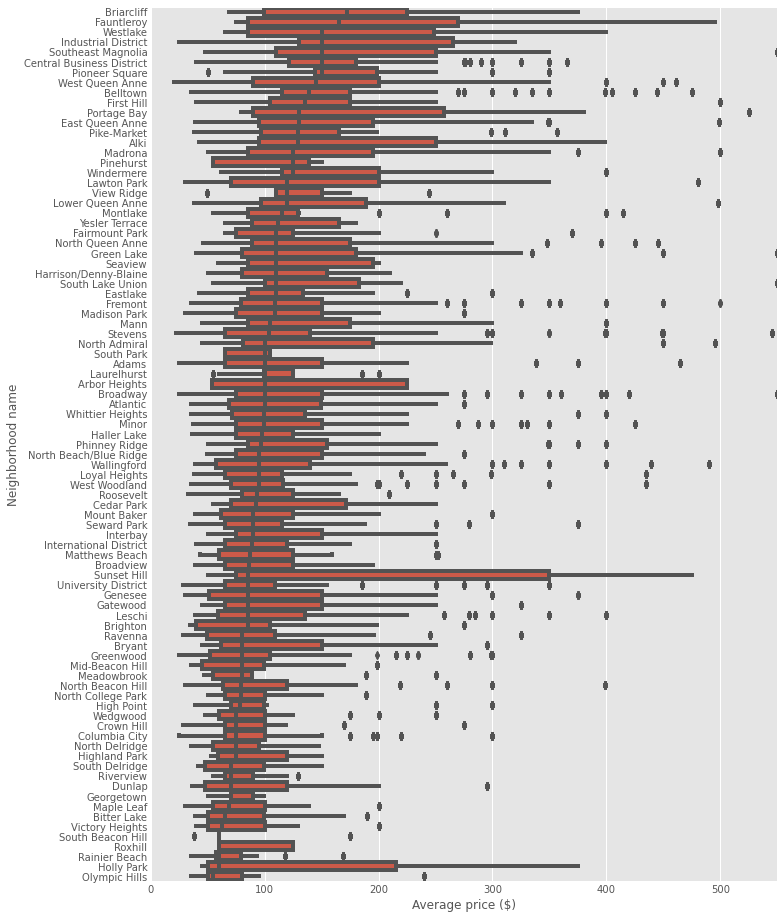

In [100]:
base_color = sb.color_palette()[0]
# Increase plot size
plt.figure(figsize = [10,15])
# order results descendingly by median of original_price
order = df.groupby(['neighbourhood_cleansed']).median().sort_values(['original_price'],ascending=False)['original_price'].index
# plot
sb.boxplot(data = df, y = 'neighbourhood_cleansed',x='original_price', color = base_color,order=order)
plt.xlabel('Average price ($)');
plt.ylabel('Neighborhood name');
# limit the x axis to remove ouliers for better visualization
plt.xlim([0,550]);

We can observe from the above plot how the price varies accross different neighborhood. 

In [101]:
df['date'].max() - df['date'].min()

Timedelta('364 days 00:00:00')

Plotting the change of actual prices along the year

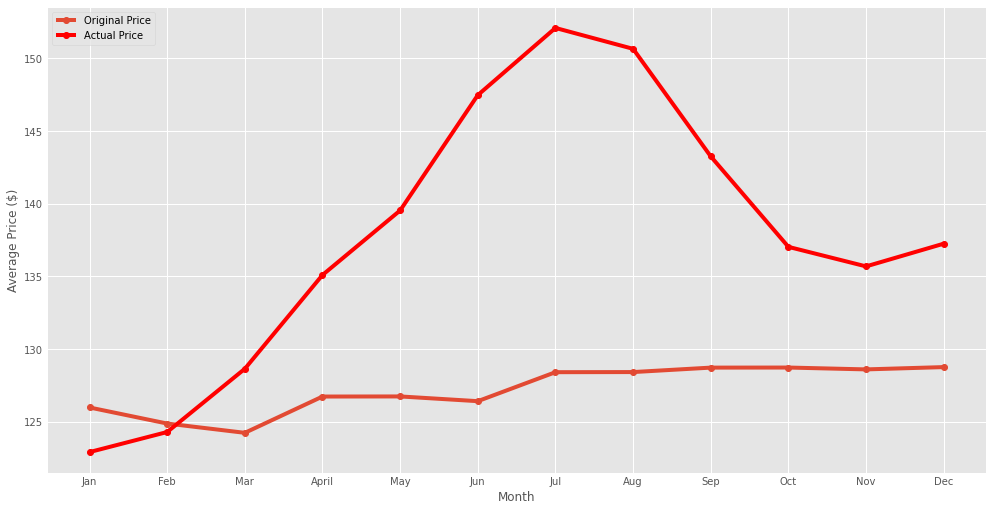

In [102]:
df['month'] = df['date'].dt.month
plt.figure(figsize = [15,8])
plt.style.use('ggplot')

# Plotting
y_org_values = df.groupby(['month'])['original_price'].mean()
y_act_values = df.groupby(['month'])['price'].mean()
x_values = ['Jan', 'Feb', 'Mar', 'April','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.plot(x_values,y_org_values, '-o',color=base_color,label = 'Original Price')
plt.plot(x_values,y_act_values, 'r-o',label = 'Actual Price')

plt.legend(loc="upper left")
plt.xlabel('Month')
plt.ylabel('Average Price ($)');

We can observe that there are months with a huge gap from original price such as summer months while the first months of the year has small gap

Now we are ansering the question about final score review we calculated earlier

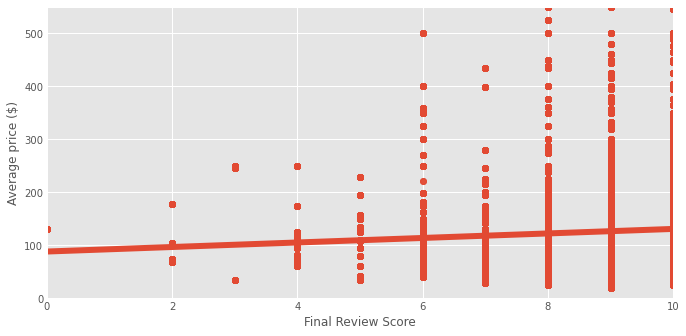

In [103]:
plt.figure(figsize = [10,5])

sb.regplot(data = df, x= 'final_review_score',y='original_price',color=base_color)
plt.ylim(0, 550);
plt.ylabel('Average price ($)');
plt.xlabel('Final Review Score');

As expected, the price shows a linear relationship with the reviws, so a AirBnb houses with higher rating, tend to have higher prices.

Next Question is the relation between having an internet service and price 

Text(0, 0.5, 'Listings')

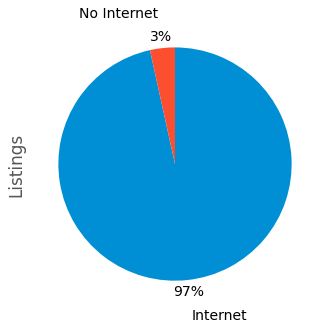

In [104]:
plt.figure(figsize = [5,5])
sorted_counts = df['Internet'].value_counts()
plt.style.use('fivethirtyeight')
plt.pie(sorted_counts,startangle = 90, counterclock = False, labels = ['Internet','No Internet'], autopct='%1.0f%%',\
       pctdistance=1.1,labeldistance=1.3);
plt.ylabel('Listings')

This shows that 3% only that don't have internet only which make the data for getting the diffrence to price is relatively small

In [ ]:
plt.figure(figsize = [5,5])
plt.style.use('ggplot')

sb.barplot(data = df, y = 'original_price',x='Internet', color = base_color)
plt.ylabel('Average price ($)');
plt.xlabel('Internet Availability');

plt.xticks(ticks = [0,1], labels = ['Not Available','Available']);

Diffrence between having an internet service or not effect on price is within 10$ but we can't assure that due to the small number of listings that don't have internet service

 Next Question: Is Bed Type a relative attribute ?

In [ ]:
plt.figure(figsize = [5,5])
plt.style.use('ggplot')

sb.barplot(data = df, y = 'original_price',x='bed_type', color = base_color)
plt.ylabel('Average price ($)');
plt.xlabel('Bed Types');

plt.xticks(ticks = [0,1,2,3,4], labels = ['Real Bed' ,'Futon', 'Pull-out Sofa', 'Airbed' ,'Couch']);

According to the graph yes bed type effect the price but we can’t limit the scope of average price value on this feature alone where having real bed is connected to some other features such as size of the property and neighborhood which can also be very effective to the average property price.

Next Question: Cancelation Policy & Price

In [ ]:
plt.figure(figsize = [5,5])
plt.style.use('ggplot')

sb.barplot(data = df, y = 'original_price',x='cancellation_policy', color = base_color)
plt.ylabel('Average price ($)');
plt.xlabel('Cancellation Policy');

plt.xticks(ticks = [0,1,2], labels = df['cancellation_policy'].unique());

As you can see having a strict cancelation policy to your property can have an impact on your average listing price.
Which can be due to that having a strict policy can show your professional attitude towards listing your property which can give the customers confidence to spend more.

In [ ]:
df.corr()['original_price'].sort_values(ascending=False)

We can see from the above plot that useful columns in our case are:
* price
* accommodates
* bedrooms
* beds
* cleaning_fee
* guests_included
* review_scores_location
* latitude
* bathrooms
* host_listing_count

And we can add a couple of columns which we think might have an effect on the price prediction:

* longitude
* final_review_score
* minimum_nights
* Extra People
* availability_30
* month

We should check for missing values in these columns and impute them if any.

In [ ]:
df[['price',
'accommodates',
'bedrooms',
'beds',
'cleaning_fee',
'guests_included',
'review_scores_location',
'latitude',
'bathrooms',
'host_listings_count',
'longitude',
'final_review_score',
'minimum_nights',
'extra_people',
'availability_30',
'month']].isnull().sum()

In [ ]:
df.corr()['host_listings_count'].sort_values(ascending=False)

We found NA values in the data fram so we removed them so they do not affect the model

In [ ]:
df.dropna(subset=['host_listings_count'],inplace = True)

In [ ]:
df[['price',
'accommodates',
'bedrooms',
'beds',
'cleaning_fee',
'guests_included',
'review_scores_location',
'latitude',
'bathrooms',
'host_listings_count',
'longitude',
'final_review_score',
'minimum_nights',
'extra_people',
'availability_30',
'month']].isnull().sum()

Checking again that we don't have any null values

In [ ]:
X = df.select_dtypes(np.number).drop(['listing_id','scrape_id','host_id','reviews_per_month',\
                                      'review_scores_rating','review_scores_communication','review_scores_checkin',\
                                     'review_scores_cleanliness','review_scores_value','review_scores_accuracy',
                                     'host_is_superhost','host_identity_verified','original_price','maximum_nights',\
                                     'availability_60','availability_90','availability_365','number_of_reviews',\
                                     'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',\
                                     'calculated_host_listings_count'],axis = 1)
y = df['original_price']

Droping unwanted columns

### Price prediction

We create the **X** matrix which holds the features of the model, and the **y** matrix which holds the variable that we're trying to predict, in our case the **original_price** variable.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 50)
# instantiate
lm_model = LinearRegression(normalize = True)
# fit
lm_model.fit(X_train, y_train) #training the algorithm
# predict
y_test_pred = lm_model.predict(X_test)
# score
"The r-squared error for the model was {}".format(r2_score(y_test,y_test_pred))

# Results
Linear regression model r-squared error was 0.852 which is relatively good


# Summary

Many features have influence on the price of an AirBnb home. we deducted that visiting Seattle in winter is cheaper, having an internet service isn’t a must. Improving your bed type can increase your price and your cancelation policy can be affective as well

Finally we used a linear regression model to predict the price of an AirBnB home, and that gave us an r-squared error of 0.852